# Train a RNN network

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Main script used for training."""
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from tensorflow.keras.models import load_model
import keras.metrics
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from nmp import model as mod
from nmp import dataset, ev_metrics
from nmp.dataset import pyplot_piano_roll
from nmp import plotter
from pathlib import Path
import time
import math
import pypianoroll
from pypianoroll import Multitrack, Track
import numpy as np
import random
import copy

SAVE = 0
NOTES = '-' + 'lstm'

# P = Path(__file__).parent.absolute()
P = Path(os.path.abspath(''))  # Compatible with Jupyter Notebook
P2 = Path('S:\datasets')  # Dataset path

PLOTS = P / 'plots'  # Plots path
FS = 24  # Sampling frequency. 10 Hz = 100 ms
Q = 0  # Quantize?
st = 10  # Past timesteps
num_ts = 10  # Predicted timesteps
DOWN = 12  # Downsampling factor

# D = "data/Piano-midi.de"  # Dataset
# D = "data/Nottingham"  # Dataset
D = "data/POP909" #Dataset
# D = "data/JSB Chorales"  # Dataset
# D = "data/MuseData"  # Dataset

# 49-key keyboard
# LOW_LIM = 36  # C2
# HIGH_LIM = 85  # C6

# 64-key keyboard
LOW_LIM = 33  # A1
HIGH_LIM = 97  # C7

# Complete 88-key keyboard
# LOW_LIM = 21  # A0
# HIGH_LIM = 109  # C8

NUM_NOTES = HIGH_LIM - LOW_LIM
CROP = [LOW_LIM, HIGH_LIM]  # Crop plots

LOAD = 0
TRANS = 0

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Using TensorFlow backend.


### Generate list of MIDI files

In [3]:
train_list = [x for x in os.listdir(P / D / 'train') if x.endswith('.mid')]
validation_list = [x for x in os.listdir(P / D / 'valid') if x.endswith('.mid')]

# train_list = [train_list[x] for x in range(10)]
# validation_list = [validation_list[x] for x in range(5)]

print("\nTrain list:  ", train_list)
print("\nValidation list:  ", validation_list)


Train list:   ['504.mid', '605.mid', '158.mid', '385.mid', '613.mid', '758.mid', '641.mid', '598.mid', '034.mid', '800.mid', '714.mid', '334.mid', '615.mid', '415.mid', '612.mid', '680.mid', '284.mid', '091.mid', '126.mid', '010.mid', '817.mid', '901.mid', '090.mid', '905.mid', '395.mid', '609.mid', '314.mid', '272.mid', '630.mid', '182.mid', '595.mid', '174.mid', '547.mid', '084.mid', '391.mid', '221.mid', '856.mid', '132.mid', '259.mid', '349.mid', '839.mid', '871.mid', '016.mid', '105.mid', '278.mid', '848.mid', '517.mid', '486.mid', '563.mid', '233.mid', '752.mid', '274.mid', '607.mid', '762.mid', '008.mid', '318.mid', '532.mid', '139.mid', '313.mid', '573.mid', '383.mid', '343.mid', '874.mid', '290.mid', '264.mid', '157.mid', '390.mid', '470.mid', '840.mid', '577.mid', '454.mid', '412.mid', '592.mid', '491.mid', '757.mid', '121.mid', '097.mid', '053.mid', '421.mid', '776.mid', '647.mid', '803.mid', '778.mid', '894.mid', '210.mid', '779.mid', '388.mid', '628.mid', '171.mid', '689.

## Datasets

### Generate data from lists
Training, validation and test sets.

In [ ]:
start = time.time()

train = dataset.Dataset(train_list, P / D / 'train',  fs=FS, bl=0, quant=Q)
validation = dataset.Dataset(validation_list, P / D / 'valid',  fs=FS, bl=0, quant=Q)

train.build_rnn_dataset("training", down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
validation.build_rnn_dataset("validation", down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

end = time.time()
print("Done")
print("Loading time: %.2f" % (end-start))

Building training dataset (581 files)
Building validation dataset (146 files)


In [ ]:
print(train.dataset[0].shape)
print(train.dataset[1].shape)
print(validation.dataset[0].shape)
print(validation.dataset[1].shape)
# print(test.dataset[0].shape)
# print(test.dataset[1].shape)

# pyplot_piano_roll(test.dataset[1][:, :NUM_NOTES], cmap="Oranges",
#                   low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Test target")
# plt.ylim(CROP)

In [ ]:
seq_length = 100

train_dataset = tf.data.Dataset.from_tensor_slices((train.dataset[0]))
train_sequences = train_dataset.batch(seq_length, drop_remainder=True)

valid_dataset = tf.data.Dataset.from_tensor_slices((validation.dataset[0]))
valid_sequences = valid_dataset.batch(seq_length, drop_remainder=True)

# test_dataset = tf.data.Dataset.from_tensor_slices((test.dataset[0]))
# test_sequences = test_dataset.batch(10, drop_remainder=True)

train_dataset

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:, :10*64]
    target_text = chunk[:, 10*64:]
#     tf.reshape(target_text, shape=[100, 640])
#     input_text = chunk[:-1]
#     target_text = chunk[1:]
    return input_text, target_text

def split_input_target_base(chunk):
    input_text = chunk[:,:10]
    target_text = chunk[:,10:]
#     input_text = chunk[:-1]
#     target_text = chunk[:-1]
    return input_text, target_text

train_data = train_sequences.map(split_input_target)
valid_data = valid_sequences.map(split_input_target)
# test_data = test_sequences.map(split_input_target)
# baseline_data = test_sequences.map(split_input_target_base)

train_data

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
valid_data = valid_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
# test_data = test_data.batch(1, drop_remainder=True)
# baseline_data = baseline_data.batch(1, drop_remainder=True)
print("Train: ", train_data)
print("Valid: ", valid_data)
# print("Test: ", test_data)
# print("Baseline: ", baseline_data)

In [ ]:
for input_batch, label_batch in train_data.take(1):
    print(input_batch.shape)
    print(label_batch.shape)

### Save dataset

### Piano rolls of training dataset
Input and output piano rolls

In [11]:
# plt.rcParams["figure.figsize"] = (20, 8)
# pyplot_piano_roll(train.dataset[0][:, 0, :],
#                   low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Train data")
# plt.ylim(CROP)
# pyplot_piano_roll(train.dataset[1][:, :NUM_NOTES], cmap="Oranges",
#                   low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Train target")
# plt.ylim(CROP)

## Keras
### Build the model

In [12]:
BS = BATCH_SIZE  # Batch size
import importlib
importlib.reload(mod)
importlib.reload(dataset)
import time

In [1]:
if LOAD:
    model = load_model(filepath=model_path,
                       custom_objects=None,
                       compile=True)

else:
    # model = mod.build_gru_model(NUM_NOTES, BS)
    model = mod.build_lstm_model(NUM_NOTES, BS)
    mod.compile_model(model, 'binary_crossentropy', 'adam',
                      metrics=['accuracy'])

model.summary()

now = datetime.now()

# Save logs
logger = TensorBoard(log_dir=P / 'logs' / now.strftime("%Y%m%d-%H%M%S"),
                     write_graph=True, update_freq='epoch')

csv_logger = CSVLogger(P / 'logs' / (now.strftime("%Y%m%d-%H%M%S") + '-' +
                       str(st) + '-' + str(num_ts) + '.csv'),
                       separator=',', append=False)

NameError: name 'LOAD' is not defined

### Try the model
Try the model before training

In [14]:
# for input_example_batch, target_example_batch in train_data.take(1):
#     example_batch_predictions = model(tf.cast(input_example_batch, tf.float32))
#     print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

### Checkpoints

In [15]:
# Directory where the checkpoints will be saved
checkpoint_dir = P / ('models/training_checkpoints/' + now.strftime("%Y%m%d-%H%M%S"))
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True,
    period=5)

### Fit the model
Define batch size ```BS``` and number of ```epochs```

#### fit generator

In [14]:
# # Fit generator the model.
# BS = 64  # Batch size
# epochs = 20
# start = time.time()
# size_train = math.ceil(train.dataset[0].shape[0] / BS)
# spe_train = size_train
# size_valid = math.ceil(validation.dataset[0].shape[0] / BS)
# spe_valid = size_valid
# print("Train dataset shape: ", train.dataset[0].shape, "\n")
# print("Train dataset target shape: ", train.dataset[1].shape, "\n")

# # Fit generator. Data should be shuffled before fitting.
# history = model.fit(dataset.generate((train.dataset[0], train.dataset[1]), trans=1), epochs=epochs,
#           steps_per_epoch=spe_train,
#           validation_data=dataset.generate((validation.dataset[0], validation.dataset[1])),
#           validation_steps=spe_valid,
#           callbacks=[logger, csv_logger])

# end = time.time()

#### fit

In [16]:
from tensorflow.keras.models import Model

# Fit the model.
BS = BATCH_SIZE  # Batch size
epochs = 500
start = time.time()

# Normal fit. Auto-shuffles data.
history = model.fit(train_data, validation_data=valid_data, epochs=epochs, shuffle=True,
                    callbacks=[logger, csv_logger, checkpoint_callback])

end = time.time()

Train for 59 steps, validate for 15 steps
Epoch 1/500
59/59 [==============================] - 694s 12s/step - loss: 0.3468 - accuracy: 0.8706 - val_loss: 0.2624 - val_accuracy: 0.9152
Epoch 2/500
59/59 [==============================] - 2s 26ms/step - loss: 0.2542 - accuracy: 0.9157 - val_loss: 0.2455 - val_accuracy: 0.9152
Epoch 3/500
59/59 [==============================] - 2s 26ms/step - loss: 0.2310 - accuracy: 0.9156 - val_loss: 0.2254 - val_accuracy: 0.9149
Epoch 4/500
59/59 [==============================] - 2s 26ms/step - loss: 0.2222 - accuracy: 0.9154 - val_loss: 0.2228 - val_accuracy: 0.9150
Epoch 5/500
59/59 [==============================] - 2s 26ms/step - loss: 0.2203 - accuracy: 0.9155 - val_loss: 0.2213 - val_accuracy: 0.9151
Epoch 6/500
59/59 [==============================] - 2s 26ms/step - loss: 0.2186 - accuracy: 0.9157 - val_loss: 0.2196 - val_accuracy: 0.9153
Epoch 7/500
59/59 [==============================] - 2s 26ms/step - loss: 0.2164 - accuracy: 0.9159 - val

59/59 [==============================] - 2s 26ms/step - loss: 0.1823 - accuracy: 0.9236 - val_loss: 0.1924 - val_accuracy: 0.9206
Epoch 59/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1822 - accuracy: 0.9236 - val_loss: 0.1924 - val_accuracy: 0.9206
Epoch 60/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1819 - accuracy: 0.9237 - val_loss: 0.1927 - val_accuracy: 0.9206
Epoch 61/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1817 - accuracy: 0.9238 - val_loss: 0.1923 - val_accuracy: 0.9207
Epoch 62/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1816 - accuracy: 0.9238 - val_loss: 0.1925 - val_accuracy: 0.9207
Epoch 63/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1813 - accuracy: 0.9239 - val_loss: 0.1927 - val_accuracy: 0.9204
Epoch 64/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1811 - accuracy: 0.9240 - val_loss: 0.1927 - val_accuracy: 0.9206
Epoch 65/500

Epoch 172/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1638 - accuracy: 0.9306 - val_loss: 0.2063 - val_accuracy: 0.9157
Epoch 173/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1638 - accuracy: 0.9306 - val_loss: 0.2062 - val_accuracy: 0.9159
Epoch 174/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1637 - accuracy: 0.9306 - val_loss: 0.2064 - val_accuracy: 0.9160
Epoch 175/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1636 - accuracy: 0.9307 - val_loss: 0.2064 - val_accuracy: 0.9158
Epoch 176/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1636 - accuracy: 0.9307 - val_loss: 0.2065 - val_accuracy: 0.9156
Epoch 177/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1633 - accuracy: 0.9308 - val_loss: 0.2068 - val_accuracy: 0.9156
Epoch 178/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1633 - accuracy: 0.9308 - val_loss: 0.2065 - val_accuracy:

Epoch 229/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1593 - accuracy: 0.9325 - val_loss: 0.2119 - val_accuracy: 0.9143
Epoch 230/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1593 - accuracy: 0.9325 - val_loss: 0.2121 - val_accuracy: 0.9141
Epoch 231/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1591 - accuracy: 0.9326 - val_loss: 0.2122 - val_accuracy: 0.9141
Epoch 232/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1591 - accuracy: 0.9326 - val_loss: 0.2124 - val_accuracy: 0.9142
Epoch 233/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1590 - accuracy: 0.9326 - val_loss: 0.2127 - val_accuracy: 0.9141
Epoch 234/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1590 - accuracy: 0.9326 - val_loss: 0.2121 - val_accuracy: 0.9140
Epoch 235/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1593 - accuracy: 0.9325 - val_loss: 0.2123 - val_accuracy:

Epoch 286/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1563 - accuracy: 0.9338 - val_loss: 0.2167 - val_accuracy: 0.9130
Epoch 287/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1564 - accuracy: 0.9337 - val_loss: 0.2165 - val_accuracy: 0.9134
Epoch 288/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1561 - accuracy: 0.9339 - val_loss: 0.2169 - val_accuracy: 0.9129
Epoch 289/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1560 - accuracy: 0.9339 - val_loss: 0.2168 - val_accuracy: 0.9126
Epoch 290/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1560 - accuracy: 0.9339 - val_loss: 0.2171 - val_accuracy: 0.9135
Epoch 291/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1560 - accuracy: 0.9339 - val_loss: 0.2170 - val_accuracy: 0.9126
Epoch 292/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1558 - accuracy: 0.9340 - val_loss: 0.2171 - val_accuracy:

Epoch 343/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1538 - accuracy: 0.9349 - val_loss: 0.2200 - val_accuracy: 0.9119
Epoch 344/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1538 - accuracy: 0.9349 - val_loss: 0.2204 - val_accuracy: 0.9119
Epoch 345/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1535 - accuracy: 0.9350 - val_loss: 0.2205 - val_accuracy: 0.9118
Epoch 346/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1536 - accuracy: 0.9350 - val_loss: 0.2205 - val_accuracy: 0.9120
Epoch 347/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1534 - accuracy: 0.9350 - val_loss: 0.2203 - val_accuracy: 0.9119
Epoch 348/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1535 - accuracy: 0.9350 - val_loss: 0.2202 - val_accuracy: 0.9118
Epoch 349/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1534 - accuracy: 0.9350 - val_loss: 0.2210 - val_accuracy:

Epoch 400/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1516 - accuracy: 0.9358 - val_loss: 0.2236 - val_accuracy: 0.9112
Epoch 401/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1513 - accuracy: 0.9360 - val_loss: 0.2244 - val_accuracy: 0.9111
Epoch 402/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1514 - accuracy: 0.9359 - val_loss: 0.2238 - val_accuracy: 0.9111
Epoch 403/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1513 - accuracy: 0.9360 - val_loss: 0.2236 - val_accuracy: 0.9107
Epoch 404/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1515 - accuracy: 0.9359 - val_loss: 0.2239 - val_accuracy: 0.9111
Epoch 405/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1514 - accuracy: 0.9359 - val_loss: 0.2239 - val_accuracy: 0.9109
Epoch 406/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1512 - accuracy: 0.9360 - val_loss: 0.2242 - val_accuracy:

Epoch 457/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1497 - accuracy: 0.9367 - val_loss: 0.2268 - val_accuracy: 0.9105
Epoch 458/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1496 - accuracy: 0.9367 - val_loss: 0.2262 - val_accuracy: 0.9105
Epoch 459/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1496 - accuracy: 0.9367 - val_loss: 0.2265 - val_accuracy: 0.9106
Epoch 460/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1495 - accuracy: 0.9368 - val_loss: 0.2268 - val_accuracy: 0.9107
Epoch 461/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1496 - accuracy: 0.9368 - val_loss: 0.2272 - val_accuracy: 0.9110
Epoch 462/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1497 - accuracy: 0.9367 - val_loss: 0.2268 - val_accuracy: 0.9110
Epoch 463/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1496 - accuracy: 0.9368 - val_loss: 0.2268 - val_accuracy:

In [17]:
('rnn-' + D[5:] + '-loss-train.dat').lower()

'rnn-pop909-loss-train.dat'

In [18]:
# model.save(str(P / 'models' / 'ff-z2-de'))
model.save(str(P / 'models' / 'lstm-501') + '.h5', save_format='h5')

### History

In [19]:
print("\nTraining time: ", (end-start), "\n")
hist = pd.DataFrame(history.history)

if SAVE:
    hist['loss'].to_csv(('tables/rnn-' + D[5:] + '-loss-train' + NOTES + '.dat').lower(), sep=' ', header=None)
    hist['val_loss'].to_csv(('tables/rnn-' + D[5:] + '-loss-valid' + NOTES + '.dat').lower(), sep=' ', header=None)

hist


Training time:  1457.1072688102722 



,loss,accuracy,val_loss,val_accuracy
0,0.346782,0.870645,0.262361,0.915203
1,0.254243,0.915713,0.245491,0.915204
2,0.231018,0.915630,0.225392,0.914931
3,0.222196,0.915435,0.222831,0.915004
4,0.220288,0.915542,0.221257,0.915141
...,...,...,...,...
495,0.148719,0.937179,0.228556,0.910156
496,0.148622,0.937194,0.228218,0.910405
497,0.148619,0.937199,0.227851,0.910096
498,0.148556,0.937247,0.228472,0.910190


### Plot loss function of training and validation sets

Training time:  1457.1072688102722


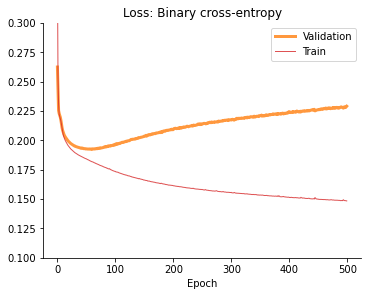

In [20]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))
plt.plot(hist['val_loss'], '-', lw=3, c='tab:orange', label='Validation', ms=8, alpha=0.8)
plt.plot(hist['loss'], '-', lw=1, c='tab:red', label='Train', ms=8, alpha=0.8)
plt.xlabel('Epoch')
# plt.xticks(range(epochs))
plt.legend()
plt.title('Loss: Binary cross-entropy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([0.1, 0.3])
# fig.savefig(PLOTS / 'compare-lstm-loss.eps', fmt='eps')
print("Training time: ", (end-start))

KeyError: 'f1'

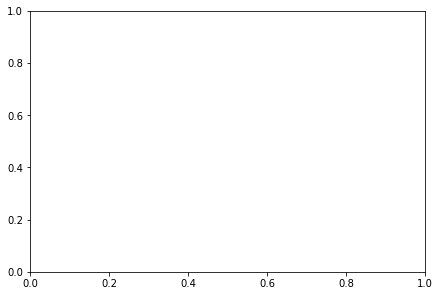

In [21]:
    # F1 score.
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))
    plt.plot(hist['f1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
    plt.plot(hist['val_f1'], 'o-', c='tab:orange', label='Validation', ms=8,
             alpha=0.8)
    plt.xlabel('Epoch', fontsize='x-large')
    plt.legend(fontsize='x-large')
    plt.title('F1 Score', fontsize='x-large')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax = plt.gca()
    ax.tick_params(labelsize='x-large')


KeyError: 'precision_1'

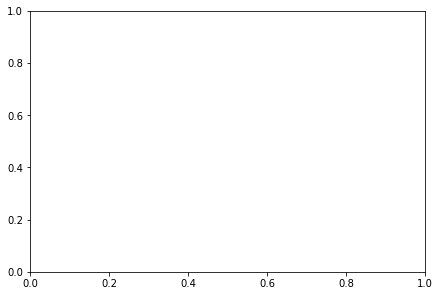

In [22]:
    # Precision
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))
    plt.plot(hist['precision_1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
    plt.plot(hist['val_precision_1'], 'o-', c='tab:orange', label='Validation', ms=8, alpha=0.8)
    plt.xlabel('Epoch', fontsize='x-large')
    plt.legend(fontsize='x-large')
    plt.title('Precision', fontsize='x-large')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax = plt.gca()
    ax.tick_params(labelsize='x-large')


## Save model to file
Model can be loaded with:
``` python
load_model(filepath=str(folder_path), compile=True)
```

In [49]:
# model.save(str(P / 'models' / 'simpleRNN-nottingham-3') + '.h5', save_format='h5')
# model.save(str(P / 'models' / 'lstm-z-de') + '.h5', save_format='h5')

### Model evaluation

In [21]:
print("Evaluation on train set:")
e_train = model.evaluate(train_data)

print("\nEvaluation on validation set:")
e_valid = model.evaluate(valid_data)

# print("\nEvaluation on test set:")
# e_test = model.evaluate(test_data)

results = {out: e_train[i] for i, out in enumerate(model.metrics_names)}
res = pd.DataFrame(list(results.items()), columns=['metric', 'train'])
res = res.set_index('metric')

results2 = {out: e_valid[i] for i, out in enumerate(model.metrics_names)}
res2 = pd.DataFrame(list(results2.items()), columns=['metric', 'validation'])
res2 = res2.set_index('metric')

# results3 = {out: e_test[i] for i, out in enumerate(model.metrics_names)}
# res3 = pd.DataFrame(list(results3.items()), columns=['metric', 'test'])
# res3 = res3.set_index('metric')
res3 = pd.DataFrame([])

result = pd.concat([res, res2, res3], axis=1, sort=False)
result

Evaluation on train set:
59/59 [==============================] - 1s 13ms/step - loss: 0.1471 - accuracy: 0.9380

Evaluation on validation set:
15/15 [==============================] - 0s 12ms/step - loss: 0.2301 - accuracy: 0.9098


,train,validation
metric,,
loss,0.147144,0.230088
accuracy,0.937974,0.909784


## Make predictions
Predictions from test dataset

### Restore last checkpoint

Build again the model and restore the checkpoint with weights to use a different batch size for test.

In [22]:
# model = mod.build_gru_model(NUM_NOTES, 1)
model = mod.build_lstm_model(NUM_NOTES, 1)
mod.compile_model(model, 'binary_crossentropy', 'adam',
                  metrics=['accuracy'])
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))


In [23]:
test_list = [x for x in os.listdir(P / D / 'test') if x.endswith('.mid')]
# test_list = [test_list[x] for x in range(3)]
test = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=0, quant=Q)
test.build_rnn_dataset("test", down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
test.dataset[0].shape

Building test dataset (183 files)


(115221, 1280)

In [24]:
test_dataset = tf.data.Dataset.from_tensor_slices((test.dataset[0]))
test_sequences = test_dataset.batch(50, drop_remainder=True)
test_data = test_sequences.map(split_input_target)
test_data = test_data.batch(1, drop_remainder=True)

In [25]:
predictions = model.predict(test_data)

In [26]:
predictions_bin = dataset.ranked_threshold(predictions[:, 0, :NUM_NOTES], 1, 3)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc49855d150>)

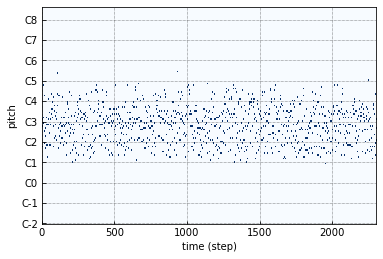

In [27]:
pyplot_piano_roll(predictions_bin, low_lim=LOW_LIM, high_lim=HIGH_LIM)

## Load tests dataset (standard way)

In [28]:
# importlib.reload(dataset)
# st = 10  # Past timesteps
# num_ts = 10  # Predicted timesteps

# test_list = [x for x in os.listdir(P / D / 'test') if x.endswith('.mid')]
# # test_list = test_list[:20]
# test = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=0, quant=Q)
# test.build_dataset("test", step=st, t_step=num_ts, steps=st,
#                    down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

In [29]:
# print(test.dataset[0].shape)
# pyplot_piano_roll(test.dataset[0][:, 0, :], low_lim=LOW_LIM, high_lim=HIGH_LIM)

In [30]:
# reshaped = test.dataset[0].reshape(len(test.dataset[0]), 640)
# reshaped.shape

### Make predictions

In [31]:
# import importlib
# importlib.reload(dataset)

# rnn_predictions = []
# for c, t in enumerate(reshaped):
#     rnn_predictions.append(dataset.predict_rnn(t, model))
#     if c % 1000 == 0:
#         print("Processed timestep %d" % c)
#     pyplot_piano_roll(rnn_predictions, low_lim=LOW_LIM, high_lim=HIGH_LIM)
#     pyplot_piano_roll(t, low_lim=LOW_LIM, high_lim=HIGH_LIM)
#     break

# rnn_predictions = np.array(rnn_predictions)

In [32]:
# pyplot_piano_roll(rnn_predictions[:, 1, :], low_lim=LOW_LIM, high_lim=HIGH_LIM)

### Evaluate AUC-ROC
Reshape predictions

In [33]:
# predictions = rnn_predictions.reshape([len(rnn_predictions), 640])


In [34]:
# # # Build baseline
# L = test.dataset[0].shape[0]
# baseline = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=1, quant=Q)
# baseline.build_dataset("baseline", step=st, t_step=num_ts, steps=st,
#                        down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

# print("")
# print("Baseline shape: ", baseline.dataset[1].shape)
# print("Test shape: ", test.dataset[1].shape)

# pred_auc = ev_metrics.compute_auc(test.dataset[1][:L, :], predictions, NUM_NOTES)
# base_auc = ev_metrics.compute_auc(test.dataset[1][:L, :], baseline.dataset[1][:L, :], NUM_NOTES)

In [35]:
# fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
#                                      figsize=(8, 8),
#                                      gridspec_kw={'width_ratios':[1, 1, 0.08]})
# g1 = sns.heatmap(pred_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax1, cbar=False)
# g1.set_ylabel('')
# g1.set_xlabel('')
# g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
# ax1.set_xlabel('Time (step)')
# ax1.set_ylabel('Pitch')
# ax1.set_title('AUC-ROC (prediction)')
# g2 = sns.heatmap(base_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax2, cbar_ax=axcb)
# g2.set_ylabel('')
# g2.set_xlabel('')
# g2.set_yticks([])
# ax2.set_xlabel('Time (step)')
# ax2.set_title('AUC-ROC (baseline)')
# ax1.get_shared_y_axes().join(ax1,ax2)
# # plt.savefig(PLOTS / 'heat.eps', format='eps')
# print(pred_auc.shape)

In [36]:
# c1 = 0
# c2 = 64
# fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
#                                      figsize=(8, 6),
#                                      gridspec_kw={'width_ratios':[1, 1, 0.08]})
# g1 = sns.heatmap(pred_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax1, cbar=False)
# g1.set_ylabel('')
# g1.set_xlabel('')
# g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
# ax1.set_xlabel('Time (step)')
# ax1.set_ylabel('Pitch')
# ax1.set_title('AUC-ROC (crop) [prediction]')
# g2 = sns.heatmap(base_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax2, cbar_ax=axcb)
# g2.set_ylabel('')
# g2.set_xlabel('')
# g2.set_yticks([])
# ax2.set_xlabel('Time (step)')
# ax2.set_title('AUC-ROC (crop) [baseline]')
# ax1.get_shared_y_axes().join(ax1,ax2)
# # plt.savefig(PLOTS / 'heat_crop.eps', format='eps')
# print(pred_auc.shape)

In [37]:
# fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))

# ax.plot(range(1, num_ts + 1), np.mean(pred_auc[c1:c2]), 'x', c='tab:blue', label='prediction', ms=10)
# ax.plot(range(1, num_ts + 1), np.mean(base_auc[c1:c2]), 'o', c='tab:green', label='baseline ', ms=7)

# ax.set_ylim([0.4, 1])
# ax.set_ylim([0.4, 1])
# ax.legend()
# plt.title('Avg. AUC-ROC per predicted timestep')
# plt.xlabel('Timestep')
# # plt.xticks([0, 2, 4, 6, 8, 10])
# plt.ylabel('ROC AUC')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# name = 'auc' + str()
# plt.grid()
# # plt.savefig(PLOTS / 'rnn10.eps', format='eps')

# print("Predict. mean value:", np.mean(np.mean(pred_auc[c1:c2])))
# print("Baseline mean value:", np.mean(np.mean(base_auc[c1:c2])))

In [38]:
# np.mean(pred_auc[c1:c2])

In [39]:
# np.mean(base_auc[c1:c2])

# Other 

In [40]:
model.reset_states()
predauc = []
baseauc = []

merged_input = []
merged_output = []
merged_pred = []

for input_batch, label_batch in test_data.take(-1):
    predictions = model(tf.cast(input_batch, tf.float32))

    pred = np.array(tf.squeeze(predictions, 0))
    inp = np.array(tf.squeeze(input_batch, 0))
    out = np.array(tf.squeeze(label_batch, 0))

    # Merged piano rolls to compute overall AUC.
    merged_input.append(inp)
    merged_output.append(out)
    merged_pred.append(pred)

merged_input = np.concatenate([x for x in merged_input])
merged_output = np.concatenate([x for x in merged_output])
merged_pred = np.concatenate([x for x in merged_pred])

# merged_input = merged_input.reshape((len(merged_input), 10, 64))
# merged_output = merged_output.reshape((len(merged_output), 10, 64))
# merged_pred = merged_pred.reshape((len(merged_pred), 10, 64))

print(merged_input.shape)

baseline = copy.deepcopy(merged_input)
for t in range(len(merged_input)):
    for s in range(10):
        baseline[t, 64*s:64*(s+1)] = merged_input[t, 640-64:640]

pred_auc = ev_metrics.compute_auc(merged_output, merged_pred, NUM_NOTES)
base_auc = ev_metrics.compute_auc(merged_output, baseline, NUM_NOTES)

# print("Pred AUC-ROC (mean of subsets): ", np.mean(predauc))
# print("Base AUC-ROC:(mean of subsets): ", np.mean(baseauc))

# print("Pred AUC-ROC (global): ", np.mean(np.mean((pred_auc_merged))))
# print("Base AUC-ROC (global): ", np.mean(np.mean((base_auc_merged))))


# # pyplot_piano_roll(test.dataset[1][:, :NUM_NOTES],
# #                   cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Test target (ground truth)")


# plt.rcParams["figure.figsize"] = (13, 4)
# pyplot_piano_roll(merged_output,
#                   cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Target (labels)")
# plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll1.png")
# pyplot_piano_roll(merged_pred[:, :NUM_NOTES],
#                   cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Predictions")
# plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll2.png")
# pyplot_piano_roll(merged_input[:, :NUM_NOTES],
#                   cmap="Reds", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Baseline (equal to inputs)")
# plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll3.png")


(115200, 640)


(64, 10)


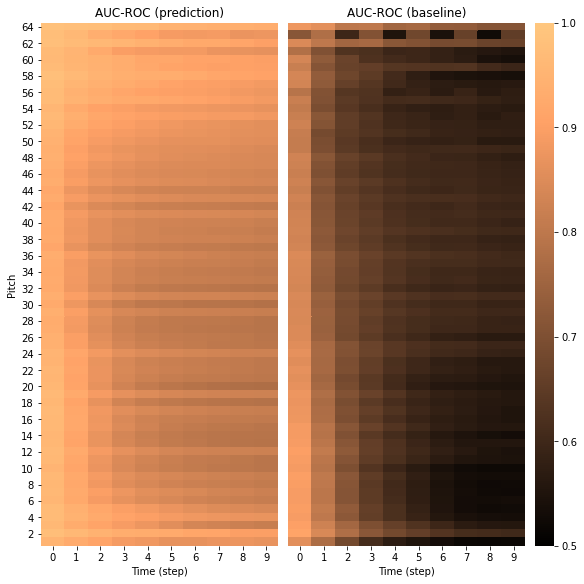

In [41]:
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
                                     figsize=(8, 8),
                                     gridspec_kw={'width_ratios':[1, 1, 0.08]})
g1 = sns.heatmap(pred_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Pitch')
ax1.set_title('AUC-ROC (prediction)')
g2 = sns.heatmap(base_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
ax2.set_xlabel('Time (step)')
ax2.set_title('AUC-ROC (baseline)')
ax1.get_shared_y_axes().join(ax1,ax2)
# plt.savefig(PLOTS / 'heat.eps', format='eps')
print(pred_auc.shape)

(64, 10)


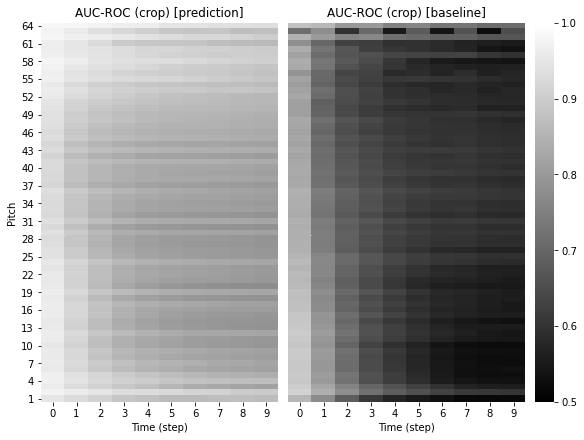

In [42]:
c1 = 0
c2 = 64
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
                                     figsize=(8, 6),
                                     gridspec_kw={'width_ratios':[1, 1, 0.08]})
g1 = sns.heatmap(pred_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Pitch')
ax1.set_title('AUC-ROC (crop) [prediction]')
g2 = sns.heatmap(base_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
ax2.set_xlabel('Time (step)')
ax2.set_title('AUC-ROC (crop) [baseline]')
ax1.get_shared_y_axes().join(ax1,ax2)
# plt.savefig(PLOTS / 'heat_crop.eps', format='eps')
print(pred_auc.shape)

Predict. mean value: 0.8670526408847614
Baseline mean value: 0.6489772002019066


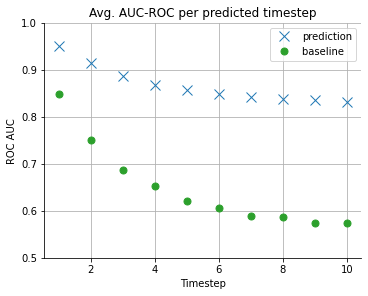

In [43]:
num_ts = 10
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))

ax.plot(range(1, num_ts + 1), np.mean(pred_auc[c1:c2]), 'x', c='tab:blue', label='prediction', ms=10)
ax.plot(range(1, num_ts + 1), np.mean(base_auc[c1:c2]), 'o', c='tab:green', label='baseline ', ms=7)

ax.set_ylim([0.5, 1])
ax.set_ylim([0.5, 1])
ax.legend()
plt.title('Avg. AUC-ROC per predicted timestep')
plt.xlabel('Timestep')
# plt.xticks([0, 2, 4, 6, 8, 10])
plt.ylabel('ROC AUC')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
name = 'auc' + str()
plt.grid()
# plt.savefig(PLOTS / 'compare-lstm-auc.eps', format='eps')

print("Predict. mean value:", np.mean(np.mean(pred_auc[c1:c2])))
print("Baseline mean value:", np.mean(np.mean(base_auc[c1:c2])))

In [44]:
if SAVE:
    auc_df = pd.DataFrame(
        {'pred': np.mean(pred_auc[c1:c2]),
         'base': np.mean(base_auc[c1:c2])})
    auc_df['pred'].to_csv(('tables/rnn-' + D[5:] + '-auc-pred' + NOTES + '.dat').lower(), sep=' ', header=None)
    auc_df['base'].to_csv(('tables/rnn-' + D[5:] + '-auc-base' + NOTES + '.dat').lower(), sep=' ', header=None)

In [45]:
inp = []
lab = []
cnt = 0
print(test_data)
for input_batch, label_batch in test_data.take(100):
    print(input_batch.shape)
    inp.append(np.array(tf.squeeze(input_batch, 0)))
    lab.append(np.array(tf.squeeze(label_batch, 0)))
inp = np.array(inp)
print(inp.shape)
pyplot_piano_roll(inp[:, 0, :], cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)

<BatchDataset shapes: ((1, 50, 640), (1, 50, 640)), types: (tf.bool, tf.bool)>
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640

ValueError: The length of the second axis of `pianoroll` must be 128.

In [46]:
def generate_data(model, input_batch, size):
    generated = []
#     print(input_batch.shape)
    for i in range(size):
#         print(input_batch.shape)
        predictions = model(tf.cast(input_batch, tf.float32))
        pred = np.array(tf.squeeze(predictions, 0))
        predictions_bin = dataset.ranked_threshold(pred, steps=1, how_many=5)

        generated.append(np.array(predictions_bin[-1]))
        input_batch = tf.expand_dims([predictions_bin[-1]], 0)
    return np.array(generated)

In [47]:
model.reset_states()
predauc = []
baseauc = []

merged_input = []
merged_output = []
merged_pred = []

size = 10
import time


predizioni = []
a = 0
for input_batch, label_batch in test_data.take(-1):
#     print(input_batch.shape)
#     time.sleep(50)
#     print(a)
    a += 1

    generated = generate_data(model, input_batch, size)

    predizioni.append(generated)
#     print("OK")
#     inp = np.array(tf.squeeze(input_batch, 0))
#     out = np.array(tf.squeeze(label_batch, 0))

#     pyplot_piano_roll(out,
#                       cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
#     plt.title("Target")
#     plt.savefig(PLOTS / "roll1.png")

#     pyplot_piano_roll(pred,
#                       cmap="Purples", low_lim=LOW_LIM, high_lim=HIGH_LIM)
#     plt.title("Predictions")
#     plt.savefig(PLOTS / "roll.png")

#     pyplot_piano_roll(inp,
#                   cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)
#     plt.title("Baseline (repetition of the input)")
#     plt.savefig(PLOTS / "roll3.png")

#     pred_auc = ev_metrics.compute_auc(out, pred, NUM_NOTES)
#     base_auc = ev_metrics.compute_auc(out, inp, NUM_NOTES)
#     predauc.append(np.mean(np.mean(pred_auc)))
#     baseauc.append(np.mean(np.mean(base_auc)))

    
#     # Merged piano rolls to compute overall AUC.
# #     merged_input.append(inp)
# #     merged_output.append(out)
# #     merged_pred.append(pred)

# # merged_input = np.concatenate([x for x in merged_input])
# # merged_output = np.concatenate([x for x in merged_output])
# # merged_pred = np.concatenate([x for x in merged_pred])

# # pred_auc_merged = ev_metrics.compute_auc(merged_output, merged_pred, NUM_NOTES)
# # base_auc_merged = ev_metrics.compute_auc(merged_output, merged_input, NUM_NOTES)

# # print("Pred AUC-ROC (mean of subsets): ", np.mean(predauc))
# # print("Base AUC-ROC:(mean of subsets): ", np.mean(baseauc))

# # print("Pred AUC-ROC (global): ", np.mean(np.mean((pred_auc_merged))))
# # print("Base AUC-ROC (global): ", np.mean(np.mean((base_auc_merged))))

# predizioni = np.array(predizioni)
# print(predizioni.shape)

# # pyplot_piano_roll(test.dataset[1][:, :NUM_NOTES],
# #                   cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Test target (ground truth)")


# # plt.rcParams["figure.figsize"] = (13, 4)
# # pyplot_piano_roll(merged_output,
# #                   cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Target (labels)")
# # plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll1.png")
# # pyplot_piano_roll(merged_pred[:, :NUM_NOTES],
# #                   cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Predictions")
# # plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll2.png")
# # pyplot_piano_roll(merged_input[:, :NUM_NOTES],
# #                   cmap="Reds", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Baseline (equal to inputs)")
# # plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll3.png")


In [48]:
for i in range(10):
    pyplot_piano_roll(predizioni[:, i, :], low_lim=LOW_LIM, high_lim=HIGH_LIM)

TypeError: list indices must be integers or slices, not tuple